In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
pip install mne


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 25.3 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gzip
import pickle as pkl
import xml.etree.ElementTree as ET
import os
import sklearn
import mne
import numpy as np
import numpy as np
import tensorflow as tf
import numpy as np
import pymc as pm
import numpy as np
import tensorflow as tf

from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, BatchNormalization, Activation, MaxPooling2D, AveragePooling2D, Dropout, GlobalAveragePooling2D, Flatten, Dense, InputLayer, SeparableConv2D
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from sklearn.svm import SVC
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import accuracy_score


In [4]:
def bin_map(label):
    if 'tool' in label:
        return 'tool'
    elif 'animal' in label:
        return 'animal'



In [5]:
def balancing(X,y):
    cow=0
    comb=0
    pen=0
    lion=0
    ax=0
    bear=0
    ape=0
    scissors=0

    for res in y:
        if 'cow' in res:
            cow+=1
        elif 'comb' in res:
            comb+=1
        elif 'pen' in res:
            pen+=1
        elif 'lion' in res:
            lion+=1
        elif 'ax' in res:
            ax+=1
        elif 'bear' in res:
            bear+=1
        elif 'ape' in res:
            ape+=1
        elif 'scissors' in res:
            scissors+=1
    l=min(cow,comb,pen,lion,ax,bear,ape,scissors)

    cow=0
    comb=0
    pen=0
    lion=0
    ax=0
    bear=0
    ape=0
    scissors=0
    X_b=[]
    Y_b=[]
    for X1,Y1 in zip(X, y):
        if ('cow' in Y1) and (cow<l):
            X_b.append(X1)
            Y_b.append(Y1)
            cow+=1
        elif ('comb' in Y1) and (comb<l):
            X_b.append(X1)
            Y_b.append(Y1)
            comb+=1
        elif ('pen' in Y1) and (pen<l):
            X_b.append(X1)
            Y_b.append(Y1)
            pen+=1
        elif ('lion' in Y1) and (lion<l):
            X_b.append(X1)
            Y_b.append(Y1)
            lion+=1
        elif ('ax' in Y1) and (ax<l):
            X_b.append(X1)
            Y_b.append(Y1)
            ax+=1
        elif ('bear' in Y1) and (bear<l):
            X_b.append(X1)
            Y_b.append(Y1)
            bear+=1
        elif ('ape' in Y1) and (ape<l):
            X_b.append(X1)
            Y_b.append(Y1)
            ape+=1
        elif ('scissors' in Y1) and (scissors<l):
            X_b.append(X1)
            Y_b.append(Y1)
            scissors+=1
    return X_b,Y_b


In [6]:
def sort_data(X, y):
    sort_order = {
        'ape': 1,
        'ax': 2,
        'bear': 3,
        'comb': 4,
        'cow': 5,
        'pen': 6,
        'lion': 7,
        'scissors': 8
    }

    def get_sort_key(item):
        for key in sort_order.keys():
            if key in item:
                return sort_order[key]
        return float('inf')

    sorted_indices = sorted(range(len(y)), key=lambda i: get_sort_key(y[i]))
    y_sorted = [y[i] for i in sorted_indices]
    X_sorted = [X[i] for i in sorted_indices]
    return X_sorted, y_sorted


In [7]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold, train_test_split
import pickle as pkl



def build_bayesian_logistic_regression_model(input_shape):
    inputs = tf.keras.Input(shape=(input_shape,))
    dense = tfp.layers.DenseFlipout(1, activation='sigmoid', kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / X.shape[0])(inputs)
    model = tf.keras.Model(inputs=inputs, outputs=dense)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])
    return model


In [8]:
def Bay_overlapping_cross_validation(X, y, i, modality, nb_classes=2):

    skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
    avg_acc = 0
    results=[]
    fold = 1
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # print(y_test)
        # print(y_train)

        input_shape = X_train.shape[1]
        model = build_bayesian_logistic_regression_model(input_shape)
        model.fit(X_train, y_train, epochs=100, verbose=1)

        y_pred_probs = model.predict(X_test)
        y_pred = (y_pred_probs >= 0.5).astype(int).flatten()

        cm = confusion_matrix(y_test, y_pred)
        cr = classification_report(y_test, y_pred, output_dict=True)
        accuracy = accuracy_score(y_test, y_pred)
        avg_acc += accuracy

        print(f"Bayesian Overlapping {modality}")
        print(f"Subject {i}")
        print(f"Fold {fold}")
        print(f"Confusion Matrix (Fold {fold}):\n{cm}")
        print(f"Classification Report (Fold {fold}):\n{classification_report(y_test, y_pred)}")

        fold += 1

    avg_acc /= 4
    results = {
        "subject": i,
        "classifier": 'Bayesian',
        "methodology": "overlapping",
        "modality": modality,
        "accuracy": avg_acc,
        "confusion_matrix": cm.tolist(),
        "classification_report": cr
    }

    return results

In [9]:

def Bay_disjoint_cross_validation(X, y, i, modality, nb_classes=2):
    avg_acc = 0
    accuracies = []
    results = []

    # KFold cross-validation splits
    kf = KFold(n_splits=4, shuffle=False)

    fold = 1
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # print(y_test)
        # print(y_train)

        # Reshaping and Standardizing
        X_train = X_train.reshape(X_train.shape[0], -1)
        X_test = X_test.reshape(X_test.shape[0], -1)

        sc = StandardScaler()
        X_train = sc.fit_transform(X_train)
        X_test = sc.transform(X_test)

        input_shape = X_train.shape[1]

        # Train and evaluate the RandomForestClassifier
        model = build_bayesian_logistic_regression_model(input_shape)
        model.fit(X_train, y_train, epochs=100, verbose=1)

        y_pred_probs = model.predict(X_test)
        y_pred = (y_pred_probs >= 0.5).astype(int).flatten()

        cm = confusion_matrix(y_test, y_pred)
        cr = classification_report(y_test, y_pred, output_dict=True)
        accuracy = accuracy_score(y_test, y_pred)
        avg_acc += accuracy

        print(f"Bayesian DISJOINT {modality}")
        print(f"Subject {i}")
        print(f"Fold {fold}")
        print(f"Confusion Matrix (Fold {fold}):\n{cm}")
        print(f"Classification Report (Fold {fold}):\n{classification_report(y_test, y_pred)}")

        fold += 1

    avg_acc= avg_acc/4
    results= {
        "subject": i,
        "classifier": 'Bayesian',
        "methodology": "disjoint",
        "modality": modality,
        "accuracy": avg_acc,
        "confusion_matrix": cm.tolist(),
        "classification_report": cr
    }
    return results

In [11]:
final=[]
for num in range(3):
    for i in range(6, 28):
        try:
            pickle_file_path = f'/content/drive/MyDrive/epochs/subj{i:02}.pkl'
            with open(pickle_file_path, 'rb') as file:
                epochs = pkl.load(file)
            modality=['picture','spoken','written']
            X = epochs[modality[num]].get_data(copy=True)
            reverse_event_id = {v: k for k, v in epochs.event_id.items()}
            y = [reverse_event_id[event] for event in epochs[modality[num]].events[:, 2]]
            X,y=balancing(X,y)
            X=np.array(X)
            y=np.array(y)

            # Making Y binary
            y_high_level = np.array([bin_map(label) for label in y])

            filtered_indices = y_high_level != None
            X = X[filtered_indices]
            y_high_level = y_high_level[filtered_indices]

            # Encoding binary labels to 0 and 1
            label_encoder = LabelEncoder()
            y_binary = label_encoder.fit_transform(y_high_level)

            # Reshaping and Standardizing the data
            X = X.reshape(X.shape[0], -1)
            sc = StandardScaler()
            X = sc.fit_transform(X)

            # Overlapping cross-validation
            result1 = Bay_overlapping_cross_validation(X, y_binary,i,modality[num])
            final.append(result1)

            X = epochs[modality[num]].get_data(copy=True)
            reverse_event_id = {v: k for k, v in epochs.event_id.items()}
            y = [reverse_event_id[event] for event in epochs[modality[num]].events[:, 2]]
            X,y=balancing(X,y)
            X=np.array(X)
            y=np.array(y)
            X,y=sort_data(X,y)
            X=np.array(X)
            y=np.array(y)


            # Making Y binary
            y_high_level = np.array([bin_map(label) for label in y])

            filtered_indices = y_high_level != None
            X = X[filtered_indices]
            y_high_level = y_high_level[filtered_indices]

            # Encoding binary labels to 0 and 1
            label_encoder = LabelEncoder()
            y_binary = label_encoder.fit_transform(y_high_level)

            # Reshaping and Standardizing the data
            X = X.reshape(X.shape[0], -1)
            sc = StandardScaler()
            X = sc.fit_transform(X)

            result2 = Bay_disjoint_cross_validation(X, y_binary,i,modality[num])
            final.append(result2)

        except Exception as e:
            print(f"An error occurred for subject {i:02}: {e}")

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


Epoch 1/100
15/15 [==============================] - 2s 28ms/step - loss: 142.1003 - accuracy: 0.5724
Epoch 2/100
15/15 [==============================] - 0s 28ms/step - loss: 134.3813 - accuracy: 0.7566
Epoch 3/100
15/15 [==============================] - 0s 25ms/step - loss: 126.9707 - accuracy: 0.8640
Epoch 4/100
15/15 [==============================] - 0s 28ms/step - loss: 123.7846 - accuracy: 0.8925
Epoch 5/100
15/15 [==============================] - 0s 25ms/step - loss: 120.5127 - accuracy: 0.9035
Epoch 6/100
15/15 [==============================] - 0s 26ms/step - loss: 117.1966 - accuracy: 0.9189
Epoch 7/100
15/15 [==============================] - 0s 28ms/step - loss: 114.4968 - accuracy: 0.9167
Epoch 8/100
15/15 [==============================] - 0s 25ms/step - loss: 111.5758 - accuracy: 0.9254
Epoch 9/100
15/15 [==============================] - 0s 28ms/step - loss: 107.8223 - accuracy: 0.9759
Epoch 10/100
15/15 [==============================] - 0s 26ms/step - loss: 104.825

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


Epoch 1/100
15/15 [==============================] - 2s 26ms/step - loss: 143.3218 - accuracy: 0.5833
Epoch 2/100
15/15 [==============================] - 0s 25ms/step - loss: 135.4803 - accuracy: 0.7456
Epoch 3/100
15/15 [==============================] - 0s 26ms/step - loss: 129.4177 - accuracy: 0.8333
Epoch 4/100
15/15 [==============================] - 0s 27ms/step - loss: 123.7628 - accuracy: 0.8838
Epoch 5/100
15/15 [==============================] - 0s 25ms/step - loss: 121.3465 - accuracy: 0.8925
Epoch 6/100
15/15 [==============================] - 0s 29ms/step - loss: 117.0483 - accuracy: 0.9408
Epoch 7/100
15/15 [==============================] - 0s 25ms/step - loss: 113.9750 - accuracy: 0.9583
Epoch 8/100
15/15 [==============================] - 0s 27ms/step - loss: 111.0182 - accuracy: 0.9693
Epoch 9/100
15/15 [==============================] - 0s 27ms/step - loss: 108.3318 - accuracy: 0.9518
Epoch 10/100
15/15 [==============================] - 0s 27ms/step - loss: 105.190

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


Epoch 1/100
15/15 [==============================] - 2s 45ms/step - loss: 143.7143 - accuracy: 0.5482
Epoch 2/100
15/15 [==============================] - 1s 44ms/step - loss: 133.3465 - accuracy: 0.7829
Epoch 3/100
15/15 [==============================] - 1s 44ms/step - loss: 126.4872 - accuracy: 0.8816
Epoch 4/100
15/15 [==============================] - 1s 40ms/step - loss: 122.6720 - accuracy: 0.9189
Epoch 5/100
15/15 [==============================] - 0s 27ms/step - loss: 119.5672 - accuracy: 0.9320
Epoch 6/100
15/15 [==============================] - 0s 26ms/step - loss: 116.2107 - accuracy: 0.9430
Epoch 7/100
15/15 [==============================] - 0s 27ms/step - loss: 113.4167 - accuracy: 0.9518
Epoch 8/100
15/15 [==============================] - 0s 26ms/step - loss: 109.6058 - accuracy: 0.9715
Epoch 9/100
15/15 [==============================] - 0s 26ms/step - loss: 106.9352 - accuracy: 0.9583
Epoch 10/100
15/15 [==============================] - 0s 27ms/step - loss: 104.312

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-11-968c157bcd3a>", line 33, in <cell line: 2>
    result1 = Bay_overlapping_cross_validation(X, y_binary,i,modality[num])
  File "<ipython-input-8-a5fbc5ef1dba>", line 16, in Bay_overlapping_cross_validation
    model.fit(X_train, y_train, epochs=100, verbose=1)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit
    tmp_logs = self.train_function(iterator)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/polymorphic_f

TypeError: object of type 'NoneType' has no len()

In [13]:
#uncomment during execution
with open('/content/drive/MyDrive/Results/BM_balanced_spoken.pkl', 'wb') as file:
    pkl.dump(final,file)

In [16]:
final=[]
for i in range(6, 28):
    try:
        pickle_file_path = f'/content/drive/MyDrive/epochs/subj{i:02}.pkl'
        with open(pickle_file_path, 'rb') as file:
            epochs = pkl.load(file)
        modality=['picture','spoken','written']
        X = epochs[modality[1]].get_data(copy=True)
        reverse_event_id = {v: k for k, v in epochs.event_id.items()}
        y = [reverse_event_id[event] for event in epochs[modality[1]].events[:, 2]]
        X,y=balancing(X,y)
        X=np.array(X)
        y=np.array(y)


        # Making Y binary
        y_high_level = np.array([bin_map(label) for label in y])

        # Filter out None values
        filtered_indices = y_high_level != None
        X = X[filtered_indices]
        y_high_level = y_high_level[filtered_indices]

        # Encoding binary labels to 0 and 1
        label_encoder = LabelEncoder()
        y_binary = label_encoder.fit_transform(y_high_level)

        # Reshaping and Standardizing the data
        X = X.reshape(X.shape[0], -1)
        sc = StandardScaler()
        X = sc.fit_transform(X)

        # Overlapping cross-validation
        result1 = Bay_overlapping_cross_validation(X, y_binary,i,modality[1])
        final.append(result1)

        X = epochs[modality[1]].get_data(copy=True)
        reverse_event_id = {v: k for k, v in epochs.event_id.items()}
        y = [reverse_event_id[event] for event in epochs[modality[1]].events[:, 2]]
        X,y=balancing(X,y)
        X=np.array(X)
        y=np.array(y)
        X,y=sort_data(X,y)
        X=np.array(X)
        y=np.array(y)


        # Making Y binary
        y_high_level = np.array([bin_map(label) for label in y])

        # Filter out None values
        filtered_indices = y_high_level != None
        X = X[filtered_indices]
        y_high_level = y_high_level[filtered_indices]

        # Encoding binary labels to 0 and 1
        label_encoder = LabelEncoder()
        y_binary = label_encoder.fit_transform(y_high_level)

        # Reshaping and Standardizing the data
        X = X.reshape(X.shape[0], -1)
        sc = StandardScaler()
        X = sc.fit_transform(X)

        result2 = Bay_disjoint_cross_validation(X, y_binary,i,modality[1])
        final.append(result2)

    except Exception as e:
        print(f"An error occurred for subject {i:02}: {e}")

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


Epoch 1/100
15/15 [==============================] - 2s 48ms/step - loss: 136.3429 - accuracy: 0.6346
Epoch 2/100
15/15 [==============================] - 1s 47ms/step - loss: 128.8116 - accuracy: 0.8077
Epoch 3/100
15/15 [==============================] - 0s 28ms/step - loss: 123.3101 - accuracy: 0.8932
Epoch 4/100
15/15 [==============================] - 0s 28ms/step - loss: 119.0731 - accuracy: 0.9231
Epoch 5/100
15/15 [==============================] - 0s 28ms/step - loss: 115.6127 - accuracy: 0.9359
Epoch 6/100
15/15 [==============================] - 0s 29ms/step - loss: 112.2405 - accuracy: 0.9573
Epoch 7/100
15/15 [==============================] - 0s 26ms/step - loss: 109.6839 - accuracy: 0.9573
Epoch 8/100
15/15 [==============================] - 0s 30ms/step - loss: 106.1819 - accuracy: 0.9530
Epoch 9/100
15/15 [==============================] - 0s 28ms/step - loss: 102.7123 - accuracy: 0.9701
Epoch 10/100
15/15 [==============================] - 0s 27ms/step - loss: 99.5323

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


Epoch 1/100
15/15 [==============================] - 1s 27ms/step - loss: 136.9304 - accuracy: 0.6303
Epoch 2/100
15/15 [==============================] - 0s 29ms/step - loss: 128.3497 - accuracy: 0.8162
Epoch 3/100
15/15 [==============================] - 0s 27ms/step - loss: 122.9685 - accuracy: 0.8953
Epoch 4/100
15/15 [==============================] - 0s 30ms/step - loss: 118.6581 - accuracy: 0.9316
Epoch 5/100
15/15 [==============================] - 0s 27ms/step - loss: 115.2559 - accuracy: 0.9423
Epoch 6/100
15/15 [==============================] - 0s 28ms/step - loss: 112.7852 - accuracy: 0.9231
Epoch 7/100
15/15 [==============================] - 0s 29ms/step - loss: 110.0203 - accuracy: 0.9209
Epoch 8/100
15/15 [==============================] - 0s 27ms/step - loss: 107.1046 - accuracy: 0.9380
Epoch 9/100
15/15 [==============================] - 0s 30ms/step - loss: 103.2203 - accuracy: 0.9509
Epoch 10/100
15/15 [==============================] - 0s 27ms/step - loss: 100.044

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


Epoch 1/100
15/15 [==============================] - 1s 28ms/step - loss: 136.9795 - accuracy: 0.6432
Epoch 2/100
15/15 [==============================] - 0s 28ms/step - loss: 128.6014 - accuracy: 0.8056
Epoch 3/100
15/15 [==============================] - 0s 29ms/step - loss: 122.9270 - accuracy: 0.8568
Epoch 4/100
15/15 [==============================] - 0s 27ms/step - loss: 118.9671 - accuracy: 0.9338
Epoch 5/100
15/15 [==============================] - 0s 31ms/step - loss: 115.6002 - accuracy: 0.9573
Epoch 6/100
15/15 [==============================] - 0s 27ms/step - loss: 112.6268 - accuracy: 0.9466
Epoch 7/100
15/15 [==============================] - 0s 30ms/step - loss: 109.5784 - accuracy: 0.9444
Epoch 8/100
15/15 [==============================] - 0s 29ms/step - loss: 106.4878 - accuracy: 0.9444
Epoch 9/100
15/15 [==============================] - 0s 29ms/step - loss: 103.0467 - accuracy: 0.9551
Epoch 10/100
15/15 [==============================] - 1s 46ms/step - loss: 100.194

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


Epoch 1/100
15/15 [==============================] - 2s 51ms/step - loss: 137.0907 - accuracy: 0.6154
Epoch 2/100
15/15 [==============================] - 1s 46ms/step - loss: 128.4221 - accuracy: 0.8098
Epoch 3/100
15/15 [==============================] - 1s 47ms/step - loss: 122.9665 - accuracy: 0.8889
Epoch 4/100
15/15 [==============================] - 0s 30ms/step - loss: 119.0998 - accuracy: 0.9124
Epoch 5/100
15/15 [==============================] - 0s 28ms/step - loss: 115.5705 - accuracy: 0.9402
Epoch 6/100
15/15 [==============================] - 0s 30ms/step - loss: 112.3421 - accuracy: 0.9573
Epoch 7/100
15/15 [==============================] - 0s 29ms/step - loss: 109.0422 - accuracy: 0.9658
Epoch 8/100
15/15 [==============================] - 0s 29ms/step - loss: 106.0163 - accuracy: 0.9594
Epoch 9/100
15/15 [==============================] - 0s 30ms/step - loss: 102.8563 - accuracy: 0.9744
Epoch 10/100
15/15 [==============================] - 0s 28ms/step - loss: 99.7568

In [15]:
final=[]
for i in range(6, 28):
    try:
        pickle_file_path = f'/content/drive/MyDrive/epochs/subj{i:02}.pkl'
        with open(pickle_file_path, 'rb') as file:
            epochs = pkl.load(file)
        modality=['picture','spoken','written']
        X = epochs[modality[2]].get_data(copy=True)
        reverse_event_id = {v: k for k, v in epochs.event_id.items()}
        y = [reverse_event_id[event] for event in epochs[modality[2]].events[:, 2]]
        X,y=balancing(X,y)
        X=np.array(X)
        y=np.array(y)


        # Making Y binary
        y_high_level = np.array([bin_map(label) for label in y])

        # Filter out None values
        filtered_indices = y_high_level != None
        X = X[filtered_indices]
        y_high_level = y_high_level[filtered_indices]

        # Encoding binary labels to 0 and 1
        label_encoder = LabelEncoder()
        y_binary = label_encoder.fit_transform(y_high_level)

        # Reshaping and Standardizing the data
        X = X.reshape(X.shape[0], -1)
        sc = StandardScaler()
        X = sc.fit_transform(X)

        # Overlapping cross-validation
        result1 = Bay_overlapping_cross_validation(X, y_binary,i,modality[2])
        final.append(result1)

        X = epochs[modality[2]].get_data(copy=True)
        reverse_event_id = {v: k for k, v in epochs.event_id.items()}
        y = [reverse_event_id[event] for event in epochs[modality[2]].events[:, 2]]
        X,y=balancing(X,y)
        X=np.array(X)
        y=np.array(y)
        X,y=sort_data(X,y)
        X=np.array(X)
        y=np.array(y)


        # Making Y binary
        y_high_level = np.array([bin_map(label) for label in y])

        # Filter out None values
        filtered_indices = y_high_level != None
        X = X[filtered_indices]
        y_high_level = y_high_level[filtered_indices]

        # Encoding binary labels to 0 and 1
        label_encoder = LabelEncoder()
        y_binary = label_encoder.fit_transform(y_high_level)

        # Reshaping and Standardizing the data
        X = X.reshape(X.shape[0], -1)
        sc = StandardScaler()
        X = sc.fit_transform(X)

        result2 = Bay_disjoint_cross_validation(X, y_binary,i,modality[2])
        final.append(result2)

    except Exception as e:
        print(f"An error occurred for subject {i:02}: {e}")

624
['not_target/animal/ape/picture' 'not_target/animal/ape/picture'
 'not_target/animal/ape/picture' 'not_target/animal/ape/picture'
 'not_target/animal/ape/picture' 'not_target/animal/ape/picture'
 'not_target/animal/ape/picture' 'not_target/animal/ape/picture'
 'not_target/animal/ape/picture' 'not_target/animal/ape/picture'
 'not_target/animal/ape/picture' 'not_target/animal/ape/picture'
 'not_target/animal/ape/picture' 'not_target/animal/ape/picture'
 'not_target/animal/ape/picture' 'not_target/animal/ape/picture'
 'not_target/animal/ape/picture' 'not_target/animal/ape/picture'
 'not_target/animal/ape/picture' 'not_target/animal/ape/picture'
 'not_target/animal/ape/picture' 'not_target/animal/ape/picture'
 'not_target/animal/ape/picture' 'not_target/animal/ape/picture'
 'not_target/animal/ape/picture' 'not_target/animal/ape/picture'
 'not_target/animal/ape/picture' 'not_target/animal/ape/picture'
 'not_target/animal/ape/picture' 'not_target/animal/ape/picture'
 'not_target/animal/a

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


Epoch 1/100
15/15 [==============================] - 4s 29ms/step - loss: 137.8583 - accuracy: 0.6325
Epoch 2/100
15/15 [==============================] - 0s 27ms/step - loss: 126.9918 - accuracy: 0.8355
Epoch 3/100
15/15 [==============================] - 0s 28ms/step - loss: 121.6923 - accuracy: 0.9167
Epoch 4/100
15/15 [==============================] - 0s 32ms/step - loss: 118.2618 - accuracy: 0.9274
Epoch 5/100
15/15 [==============================] - 0s 27ms/step - loss: 115.4777 - accuracy: 0.9338
Epoch 6/100
15/15 [==============================] - 0s 30ms/step - loss: 112.3180 - accuracy: 0.9594
Epoch 7/100
15/15 [==============================] - 0s 27ms/step - loss: 108.2097 - accuracy: 0.9829
Epoch 8/100
15/15 [==============================] - 0s 29ms/step - loss: 105.1878 - accuracy: 0.9786
Epoch 9/100
15/15 [==============================] - 0s 27ms/step - loss: 101.7915 - accuracy: 0.9722
Epoch 10/100
15/15 [==============================] - 0s 29ms/step - loss: 98.3619

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


Epoch 1/100
15/15 [==============================] - 2s 50ms/step - loss: 138.2837 - accuracy: 0.6410
Epoch 2/100
15/15 [==============================] - 0s 29ms/step - loss: 127.9097 - accuracy: 0.8419
Epoch 3/100
15/15 [==============================] - 0s 29ms/step - loss: 123.6221 - accuracy: 0.8632
Epoch 4/100
15/15 [==============================] - 0s 30ms/step - loss: 119.1222 - accuracy: 0.9167
Epoch 5/100
15/15 [==============================] - 0s 30ms/step - loss: 115.0364 - accuracy: 0.9380
Epoch 6/100
15/15 [==============================] - 0s 27ms/step - loss: 111.8369 - accuracy: 0.9487
Epoch 7/100
15/15 [==============================] - 0s 30ms/step - loss: 108.8027 - accuracy: 0.9658
Epoch 8/100
15/15 [==============================] - 0s 27ms/step - loss: 106.5413 - accuracy: 0.9423
Epoch 9/100
15/15 [==============================] - 0s 29ms/step - loss: 102.7118 - accuracy: 0.9530
Epoch 10/100
15/15 [==============================] - 0s 29ms/step - loss: 99.4528

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


Epoch 1/100
15/15 [==============================] - 1s 29ms/step - loss: 135.6805 - accuracy: 0.6560
Epoch 2/100
15/15 [==============================] - 0s 30ms/step - loss: 128.1683 - accuracy: 0.8248
Epoch 3/100
15/15 [==============================] - 0s 27ms/step - loss: 123.2773 - accuracy: 0.8782
Epoch 4/100
15/15 [==============================] - 0s 31ms/step - loss: 120.2923 - accuracy: 0.8974
Epoch 5/100
15/15 [==============================] - 0s 27ms/step - loss: 115.4780 - accuracy: 0.9444
Epoch 6/100
15/15 [==============================] - 0s 27ms/step - loss: 112.0265 - accuracy: 0.9679
Epoch 7/100
15/15 [==============================] - 0s 29ms/step - loss: 108.5396 - accuracy: 0.9722
Epoch 8/100
15/15 [==============================] - 0s 27ms/step - loss: 105.5065 - accuracy: 0.9722
Epoch 9/100
15/15 [==============================] - 0s 31ms/step - loss: 102.2107 - accuracy: 0.9701
Epoch 10/100
15/15 [==============================] - 1s 44ms/step - loss: 99.3381

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


Epoch 1/100
15/15 [==============================] - 2s 49ms/step - loss: 137.4739 - accuracy: 0.6218
Epoch 2/100
15/15 [==============================] - 1s 49ms/step - loss: 128.1457 - accuracy: 0.8120
Epoch 3/100
15/15 [==============================] - 1s 38ms/step - loss: 122.4836 - accuracy: 0.8996
Epoch 4/100
15/15 [==============================] - 0s 28ms/step - loss: 119.2790 - accuracy: 0.9295
Epoch 5/100
15/15 [==============================] - 0s 27ms/step - loss: 115.3231 - accuracy: 0.9551
Epoch 6/100
15/15 [==============================] - 0s 30ms/step - loss: 112.1672 - accuracy: 0.9551
Epoch 7/100
15/15 [==============================] - 0s 29ms/step - loss: 109.1168 - accuracy: 0.9722
Epoch 8/100
15/15 [==============================] - 0s 30ms/step - loss: 106.3796 - accuracy: 0.9487
Epoch 9/100
15/15 [==============================] - 0s 28ms/step - loss: 103.3399 - accuracy: 0.9444
Epoch 10/100
15/15 [==============================] - 0s 30ms/step - loss: 100.316

In [15]:
with open('/content/BM_picture.pkl', 'rb') as file:
    BMpic = pkl.load(file)

In [16]:
with open('/content/BM_spoken.pkl', 'rb') as file:
    BMspok = pkl.load(file)

In [17]:
with open('/content/BM_written.pkl', 'rb') as file:
    BMwrit = pkl.load(file)

In [18]:
BM_result=BMpic+BMspok+BMwrit

In [17]:
B_picture_accuracy_overlapping=[]
B_picture_accuracy_disjoint=[]
B_spoken_accuracy_overlapping=[]
B_spoken_accuracy_disjoint=[]
B_written_accuracy_overlapping=[]
B_written_accuracy_disjoint=[]

for i in range (len(BMresult)):
    if BMresult[i]['modality']=="picture" and BMresult[i]['methodology']=='overlapping' :
        B_picture_accuracy_overlapping.append(BMresult[i]['accuracy'])
    if BMresult[i]['modality']=="picture" and BMresult[i]['methodology']=='disjoint' :
        B_picture_accuracy_disjoint.append(BMresult[i]['accuracy'])
    if BMresult[i]['modality']=="spoken" and BMresult[i]['methodology']=='overlapping' :
        B_spoken_accuracy_overlapping.append(BMresult[i]['accuracy'])
    if BMresult[i]['modality']=="spoken" and BMresult[i]['methodology']=='disjoint' :
        B_spoken_accuracy_disjoint.append(BMresult[i]['accuracy'])
    if BMresult[i]['modality']=="written" and BMresult[i]['methodology']=='overlapping' :
        B_written_accuracy_overlapping.append(BMresult[i]['accuracy'])
    if BMresult[i]['modality']=="written" and BMresult[i]['methodology']=='disjoint' :
        B_written_accuracy_disjoint.append(BMresult[i]['accuracy'])

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (22,) and arg 1 with shape (0,).

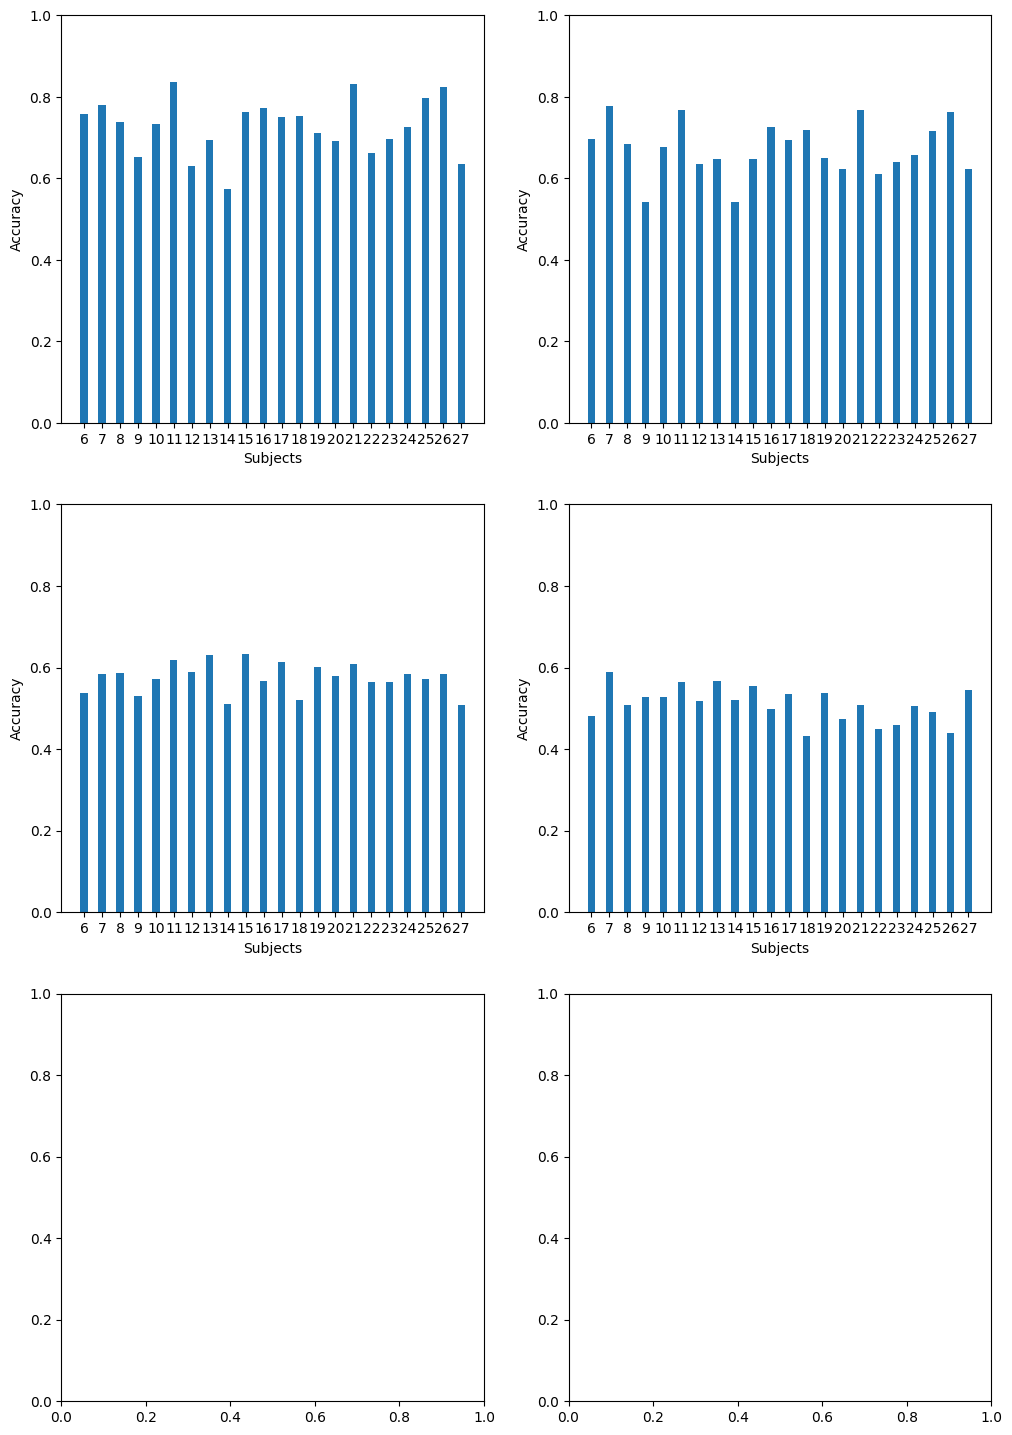

In [18]:
import matplotlib.pyplot as plt

B_accuracy_list = [
B_picture_accuracy_overlapping,
B_picture_accuracy_disjoint,
B_spoken_accuracy_overlapping,
B_spoken_accuracy_disjoint,
B_written_accuracy_overlapping,
B_written_accuracy_disjoint
]

subjects = list(range(6, 28))
fig, axs = plt.subplots(3, 2, figsize=(12, 18))
axs = axs.flatten()

for i in range(0,6):
    axs[i].bar(subjects, B_accuracy_list[i], width=0.4)
    axs[i].set_xlabel('Subjects')
    axs[i].set_ylabel('Accuracy')
    axs[i].set_xticks(subjects)
    axs[i].set_ylim(0.0, 1.0)

axs[0].set_title(f'Picture-Overlapping')
axs[1].set_title(f'Picture-Disjoint')
axs[2].set_title(f'Spoken-Overlapping')
axs[3].set_title(f'Spoken-Disjoint')
axs[4].set_title(f'Written-Overlapping')
axs[5].set_title(f'Written-Disjoint')

plt.tight_layout()
plt.show()
